In [61]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [86]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

cols = ['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet',
       'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep',
       'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'DER_lep_eta_centrality',
       'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt',
       'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
       'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta',
       'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

In [151]:
from implementations import *

In [137]:
## Preprocessing
# replace -999 by np.NaN
#tX_nan = tX
#tX_nan[tX_nan==-999] = np.nan

# remove the rows containing at least 1 NaN
idx_with_nan = set([x[0] for x in np.argwhere(tX==-999)])

tX_nonan = tX[list(set(range(len(tX)))-idx_with_nan)]
y_nonan  = y[list(set(range(len(tX)))-idx_with_nan)]

tX_fullnan = tX[list(idx_with_nan)]
y_fullnan  = y[list(idx_with_nan)]

# len(tX_nonan) -> 68'114
# len(tX_fullnan) -> 181'886 over 250'000

#Checker jet_num (eventuelle anomalie?)


In [146]:
#def least_squares_GD(y, tx, initial_w, max_iters, gamma)
    
#def least_squares_SGD(y, tx, initial_w, max_iters, gamma)
    
#def least_squares(y,tx)

#def ridge_regression(y, tx, lambda_)
    
#def logistic_regression(y, tx, initial_w, max_iters, gamma):
    
#def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


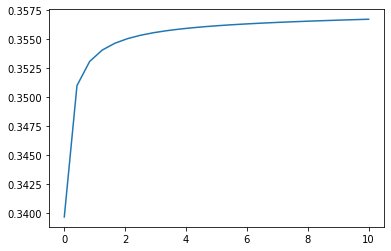

In [138]:
max_iters = 500
gammas = [0.01, 0.1, 1, 1.5]
lambdas = np.linspace(0,10,25)
initial_w = np.zeros(tX.shape[1])

losses = []
ws = []
#for gamma in gammas:
for lambda_ in lambdas:

    loss, w = ridge_regression(y, tX, lambda_)
    losses.append(loss)
    ws.append(w)
    
#plt.plot(gammas, losses)
plt.plot(lambdas, losses)

In [ ]:
seed = 1
degrees = [4, 5, 6]
k_fold = 4
lambdas = np.logspace(-4, 0, 30)
# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)
# define lists to store the loss of training data and test data
rmse_tr = []
rmse_te = []

# cross validation
for degree in degrees:
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr_k, loss_te_k = cross_validation(y, tX, k_indices, k, lambda_, degree)

            rmse_tr_tmp.append(loss_tr_k)
            rmse_te_tmp.append(loss_te_k)

        #combine the loss over the folds
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))

2.0


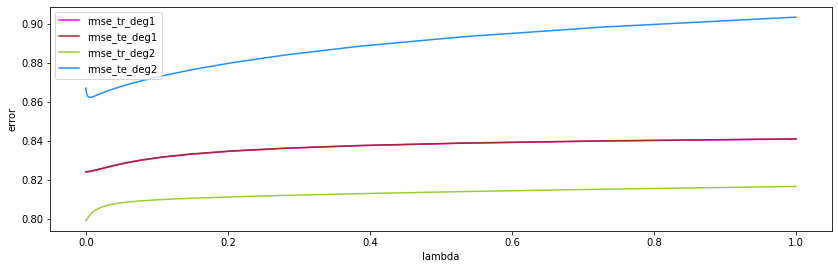

In [175]:
f = plt.figure(figsize=(14,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
ax1.plot(lambdas, rmse_tr[:30], 'magenta', label="rmse_tr_deg1")
ax1.plot(lambdas, rmse_te[:30], 'brown', label="rmse_te_deg1")
plt.xlabel("lambda")
plt.ylabel("error")

#degree 2
#ax2 = f.add_subplot(312)
ax1.plot(lambdas, rmse_tr[30:60], 'yellowgreen', label="rmse_tr_deg2")
ax1.plot(lambdas, rmse_te[30:60], 'dodgerblue', label="rmse_te_deg2")
plt.xlabel("lambda")
plt.ylabel("error")

#degree 8
#ax3 = f.add_subplot(313)
#ax1.plot(lambdas, rmse_tr[60:], 'lightskyblue')
#ax1.plot(lambdas, rmse_te[60:], 'dodgerblue')
plt.xlabel("lambda")
plt.ylabel("error")
plt.legend()
plt.show()

## Least_squares_DG

## Least_squares_SDG
Ne donne que des loss = nan, le calcul du gradient ne se passe pas bien, que ça soit avec les rows contenant du -999 ou pas.

## Least_square
degree 1 -> -334.4 (mse loss)

## Ridge_regression
Seems the most suited since we have so many features. Maybe we could remove some features if they are highly correlated (might be visible on plots?
degree = 6 -> singular matrix

## Logistic_regression
Since we have a binary output, it might be the best option...

## Reg_logistic_regression

# Remarks
if degree = 3, 7, ...
-> LinAlgError: Singular matrix



# TODO
- plot all the variable with boxplot
- compute ,np.cov between the variables
- compute Pearson correlation np.cov(x,y)/(std(x) * std(y))

In [ ]:
def predict_labels(w, x):
    return 1

## Generate predictions and save ouput in csv format for submission:

In [10]:
DATA_TEST_PATH = '/home/toinou/course/ml/ml_proj1/data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
OUTPUT_PATH = '/home/toinou/course/ml/ml_proj1/'
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)